In [22]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [23]:
df = pd.read_excel('groudon.xlsx')

In [24]:
# UNAM tiene algunos valores etiquetados como "no calculable" en la col de magnitud
df['Magnitud'] = pd.to_numeric(df['Magnitud'], errors='coerce')  # Convierte a NaN cualquier valor no numérico
df = df.dropna(subset=['Magnitud'])  # Elimina filas con valores NaN en 'Magnitud'

# Extraer año de la fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
df['Año'] = df['Fecha'].dt.year

# Limpiar nulos importantes
df = df.dropna(subset=['Latitud', 'Longitud', 'Magnitud', 'Profundidad', 'Año'])

In [25]:
def marker_shapes(year):
    if year < 1960:
        return 'star'
    elif 1961 <= year <= 1980:
        return 'square'
    elif 1981 <= year <= 2000:
        return 'triangle-down'
    elif 2001 <= year <= 2020:
        return 'triangle-up'
    else:
        return 'circle'

df['Forma'] = df['Año'].apply(marker_shapes)
df['Forma'] = 'circle'

In [26]:
# Sliders
year_slider = widgets.IntRangeSlider(
    value=[1990, df['Año'].max()],
    min=df['Año'].min(),
    max=df['Año'].max(),
    step=1,
    description='Año:',
    continuous_update=False
)

mag_slider = widgets.FloatRangeSlider(
    value=[5, df['Magnitud'].max()],
    min=df['Magnitud'].min(),
    max=df['Magnitud'].max(),
    step=0.1,
    description='Magnitud:',
    continuous_update=False
)

depth_slider = widgets.FloatRangeSlider(
    value=[df['Profundidad'].min(), df['Profundidad'].max()],
    min=df['Profundidad'].min(),
    max=df['Profundidad'].max(),
    step=1,
    description='Profundidad:',
    continuous_update=False
)

In [27]:
def mapa(rango_ano, rango_mag, rango_prof):
    df_filtrado = df[
        (df['Año'] >= rango_ano[0]) & (df['Año'] <= rango_ano[1]) &
        (df['Magnitud'] >= rango_mag[0]) & (df['Magnitud'] <= rango_mag[1]) &
        (df['Profundidad'] >= rango_prof[0]) & (df['Profundidad'] <= rango_prof[1])
    ]
    
    fig = go.Figure()

    # Añadir trazos para cada tipo de marcador
    for forma in df_filtrado['Forma'].unique():
        df_forma = df_filtrado[df_filtrado['Forma'] == forma]
        fig.add_trace(go.Scattermapbox(
            lat=df_forma['Latitud'],
            lon=df_forma['Longitud'],
            mode='markers',
            marker=dict(
                size=df_forma['Magnitud'] * 5,  # Ajustar tamaño según la magnitud
                color=df_forma['Magnitud'],
                colorscale='inferno',
                symbol=forma,  # Forma según el año
                showscale=True
            ),
            hoverinfo='text',
            hovertext=df_forma.apply(lambda row: f"{row['Referencia de localizacion']}<br>{row['Año']}", axis=1),
            name=f'Eventos {forma}'
        ))

    # Configurar el centro y el zoom para enfocar solo en México
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": 23.6345, "lon": -102.5528},  # Centro de México
        mapbox_zoom=4,  # Nivel de zoom, puedes ajustar este valor
        height=600,
        title='Groudon',
    )

    fig.show()

In [28]:
# Interfaz
ui = widgets.VBox([year_slider, mag_slider, depth_slider])
out = widgets.interactive_output(mapa, {
    'rango_ano': year_slider,
    'rango_mag': mag_slider,
    'rango_prof': depth_slider
})

display(ui, out)

Output()

In [29]:
df.head()

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus,Año,Forma
0,1900-01-20,00:33:30,7.4,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado,1900,circle
1,1900-05-16,14:12:00,6.9,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado,1900,circle
2,1901-03-05,04:45:00,6.9,25.00,-110.00,33.0,"100 km al NORESTE de LA PAZ, BCS",1901-03-05,10:45:00,revisado,1901,circle
3,1901-12-08,20:17:00,7.0,26.00,-110.00,33.0,"83 km al OESTE de AHOME, SIN",1901-12-09,02:17:00,revisado,1901,circle
4,1902-01-16,17:19:00,7.0,17.62,-99.72,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902-01-16,23:19:00,revisado,1902,circle


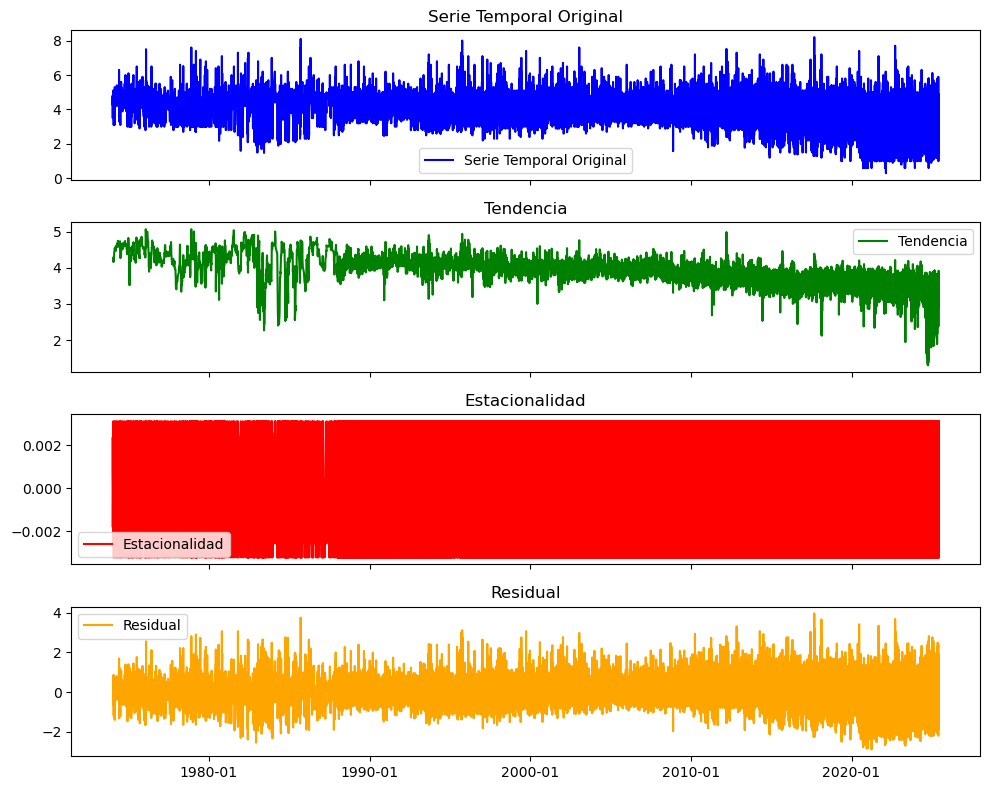

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.dates import DateFormatter


# Filtrar los datos para excluir los valores anteriores a 1974
df = df[df['Año'] >= 1974]

# Convertir 'Fecha' a datetime si aún no lo has hecho
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Descomposición STL
result = sm.tsa.seasonal_decompose(df['Magnitud'], model='additive', period=12)  # Usa period=12 si es mensual

# Graficar los componentes
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Serie Original
axs[0].plot(df['Fecha'], df['Magnitud'], label='Serie Temporal Original', color='blue')
axs[0].set_title('Serie Temporal Original')
axs[0].legend()

# Tendencia
axs[1].plot(df['Fecha'], result.trend, label='Tendencia', color='green')
axs[1].set_title('Tendencia')
axs[1].legend()

# Estacionalidad
axs[2].plot(df['Fecha'], result.seasonal, label='Estacionalidad', color='red')
axs[2].set_title('Estacionalidad')
axs[2].legend()

# Residual
axs[3].plot(df['Fecha'], result.resid, label='Residual', color='orange')
axs[3].set_title('Residual')
axs[3].legend()

# Formato de fecha para el eje X
axs[3].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()
